dividido em em duas etapas:
- Levantar os dados de pagamento para organizar as informações de forma a obter a recência, frequencia e valor de cada cliente
- Fazer a Clusterização para segmentar os clientes com base nos dados levantados na primeira etapa

# Importações e carregamento dos dados

In [1]:
# Tratamento de dados
import pandas as pd
import numpy as np
import csv

# EDA(analise exploratoria de dados)
import matplotlib.pyplot as plt
import seaborn as sns

# Dados
import calendar
from datetime import datetime

# Configs
import warnings
warnings.filterwarnings("ignore")

In [2]:
ecom = pd.read_csv('/content/drive/MyDrive/Universidade de dados/Semana 11: RFV no Python/data.csv', encoding = 'unicode_escape')
ecom.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Para fazer uma analise de RFV temos que ter, no minimo, uma chave identificadora do cliente, a data da compra e o valor monetario

In [3]:
ecom.shape

(541909, 8)

In [4]:
ecom.nunique().sort_values(ascending=False)

InvoiceNo      25900
InvoiceDate    23260
CustomerID      4372
Description     4223
StockCode       4070
UnitPrice       1630
Quantity         722
Country           38
dtype: int64

In [5]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Temos que mudar InvoiceDate de string para date
ecom['InvoiceDate'] = pd.to_datetime(ecom['InvoiceDate'])

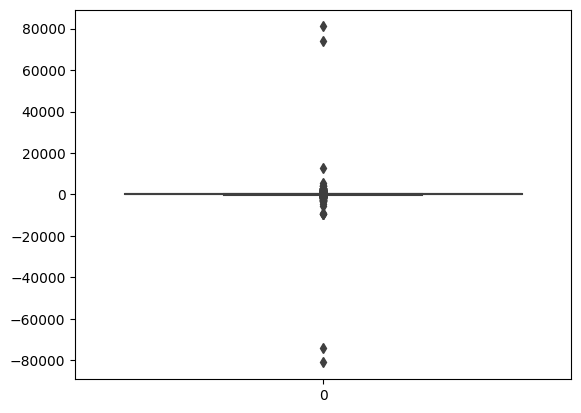

In [7]:
_ = sns.boxplot(ecom.Quantity)

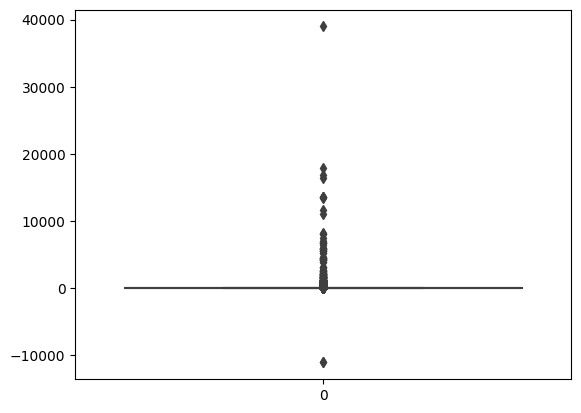

In [8]:
_ = sns.boxplot(ecom.UnitPrice)

In [9]:
ecom.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


A partir da analise sobre a quantidade e preço unitario, ficou nitido que ambos tem valores negativos, o que não era pra acontecer

In [10]:
# Titando preço e quantidade negativo
ecom = ecom.query('UnitPrice > 0 and Quantity > 0')

# Excluindo os missings de CustomerID
ecom = ecom[ecom['CustomerID'].notna()]

ecom.shape

(397884, 8)

Nesse dataset, temos a quantidade e preço unitario, mas nao temos o valor monetario(V dp RFV), que é a multiplicação dos dois primeiros, vamos criar essa coluna

In [11]:
ecom['MonetaryValue'] = ecom['Quantity'] * ecom['UnitPrice']

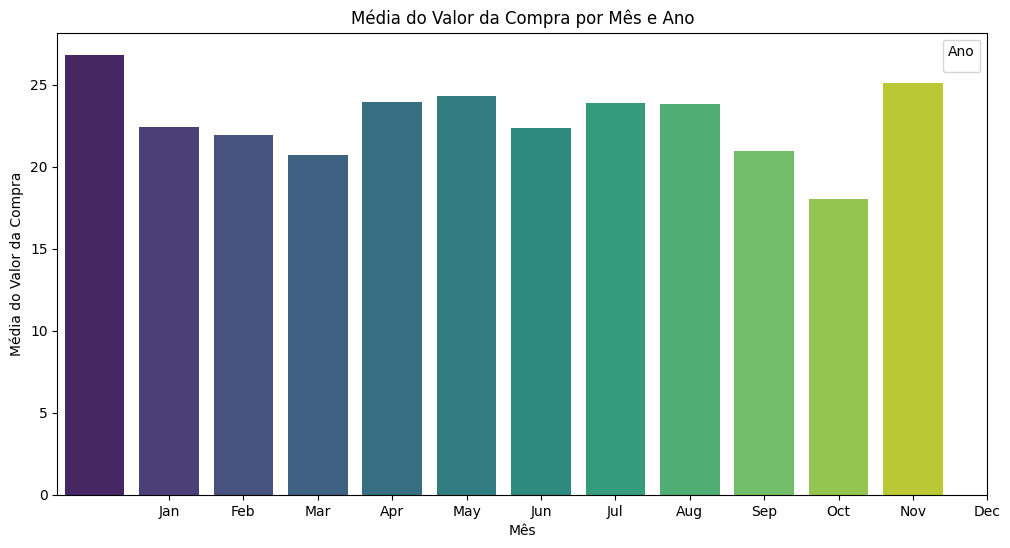

In [12]:
# Analise de sazonalidade nas compras
ecom['Month'] = ecom['InvoiceDate'].dt.month

monthly_average = ecom.groupby(['Month'])['MonetaryValue'].mean().reset_index()

# Criar o gráfico usando seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='MonetaryValue', data=monthly_average, palette='viridis')
plt.title('Média do Valor da Compra por Mês e Ano')
plt.xlabel('Mês')
plt.ylabel('Média do Valor da Compra')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Ano')
plt.show()

Text(0, 0.5, 'Quantidade')

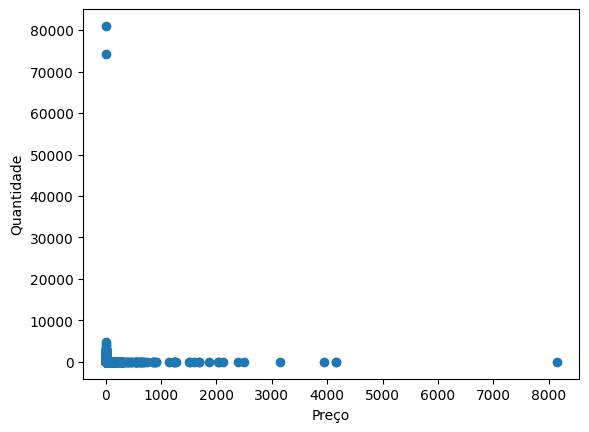

In [13]:
# Sera que a quantidade é maior se os produtos são mais baratos?
_ = plt.scatter(y= ecom.Quantity, x= ecom.UnitPrice)
plt.xlabel('Preço')
plt.ylabel('Quantidade')

In [14]:
ecom["Quantiles"] = pd.qcut(ecom.MonetaryValue, 5) # Divide em N partes e mostra em qual parte o registro está
ecom["Percentile_Rank"] = ecom.MonetaryValue.rank(pct=True) # Percentil
ecom["Rank"] = ecom.MonetaryValue.rank() # EM que posição está exatamente
ecom.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,MonetaryValue,Month,Quantiles,Percentile_Rank,Rank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,"(15.0, 20.8]",0.624769,248585.5
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,"(15.0, 20.8]",0.787735,313427.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,"(20.8, 168469.6]",0.811120,322731.5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,"(15.0, 20.8]",0.787735,313427.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,"(15.0, 20.8]",0.787735,313427.0


# RFV

## **R**ecencia

In [15]:
# DataSet com a ultima compra de cada cliente
recency = (
    ecom[['InvoiceDate', 'CustomerID']]
    .groupby('CustomerID')['InvoiceDate'].agg('max').reset_index() # Compra mais recente agrupada por cliente
)

recency.head()

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [16]:
recency.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [17]:
last_buy = recency.InvoiceDate.max() # Vamos usar a compra mais recente como referencia na comparação com outros clientes

# Vamos calcular a diferença(em meses) da compra mais recente e da compra feita por cada cliente
def diference_recency(last_date, cliente_date):
  dif = (12 * (last_date.year - cliente_date.year)) + (last_date.month - cliente_date.month)
  return dif

# Criando a coluna da diferença de meses
recency['Recency'] =  recency.InvoiceDate.apply(
    lambda datetime_val: diference_recency(last_buy, datetime_val) # Aplicamos a função com os parametros da ultima compra registrada com a ultima compra de cada registro
)

recency.head()

,CustomerID,InvoiceDate,Recency
0,12346.0,2011-01-18 10:01:00,11
1,12347.0,2011-12-07 15:52:00,0
2,12348.0,2011-09-25 13:13:00,3
3,12349.0,2011-11-21 09:51:00,1
4,12350.0,2011-02-02 16:01:00,10


In [18]:
recency.describe()

,CustomerID,Recency
count,4338.000000,4338.000000
mean,15300.408022,3.222453
std,1721.808492,3.284536
min,12346.000000,0.000000
25%,13813.250000,1.000000
50%,15299.500000,2.000000
75%,16778.750000,5.000000
max,18287.000000,12.000000


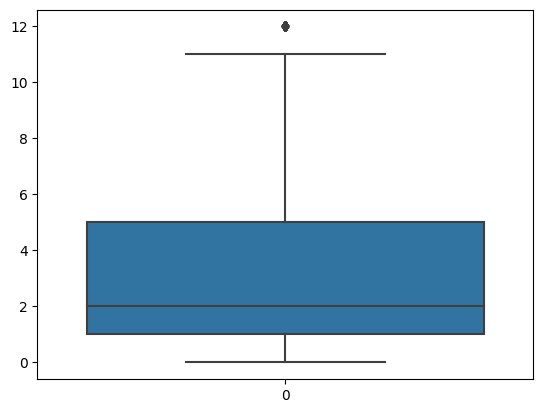

In [19]:
_ = sns.boxplot(recency.Recency)

<Axes: >

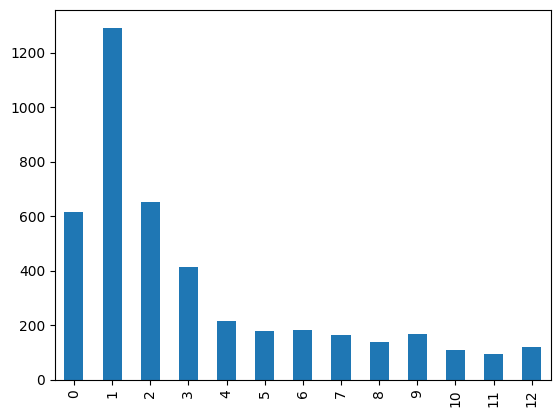

In [20]:
recency['Recency'].value_counts().sort_index().plot.bar()

In [21]:
# Como ja temos a recencia, podemos apagar a data
recency = recency.drop("InvoiceDate", axis=1)
recency.head()

,CustomerID,Recency
0,12346.0,11
1,12347.0,0
2,12348.0,3
3,12349.0,1
4,12350.0,10


## **F**requencia / **V**alor

In [22]:
ecom.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,MonetaryValue,Month,Quantiles,Percentile_Rank,Rank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,"(15.0, 20.8]",0.624769,248585.5
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,"(15.0, 20.8]",0.787735,313427.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,"(20.8, 168469.6]",0.811120,322731.5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,"(15.0, 20.8]",0.787735,313427.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,"(15.0, 20.8]",0.787735,313427.0


In [23]:
# Criando o novo DataSet de frequencia
frequency = ecom[['CustomerID', 'InvoiceNo', 'MonetaryValue']]

# Agrupando os clientes para possuir o numero de compras feitas por ele
frequency = frequency.groupby('CustomerID')['InvoiceNo', 'MonetaryValue'].agg({
    'InvoiceNo': 'count', # Numero de compras feitas por esse cliente
    'MonetaryValue': 'mean' # Media do preço pago por ele
})

frequency.reset_index()

# Renomeando para melhor entendimento
frequency = frequency.rename(columns={
    'InvoiceNo': 'Frequency',
    'MonetaryValue': 'TotalValue'
})

# Arredondando os valores
frequency.TotalValue = frequency.TotalValue.round(2)

frequency.head()

,Frequency,TotalValue
CustomerID,,
12346.0,1,77183.60
12347.0,182,23.68
12348.0,31,57.98
12349.0,73,24.08
12350.0,17,19.67


In [24]:
frequency.describe()

,Frequency,TotalValue
count,4338.000000,4338.000000
mean,91.720609,68.350452
std,228.785094,1467.918896
min,1.000000,2.100000
25%,17.000000,12.370000
50%,41.000000,17.725000
75%,100.000000,24.857500
max,7847.000000,77183.600000


<Axes: ylabel='Frequency'>

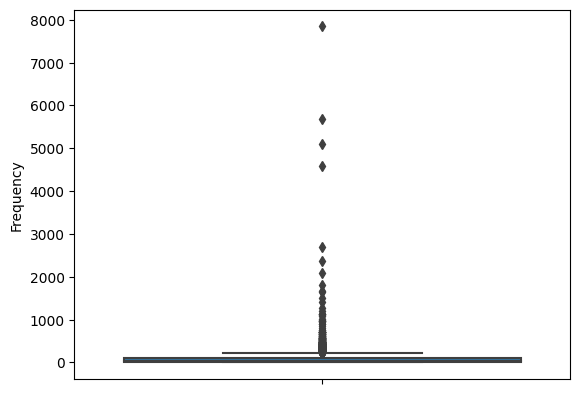

In [25]:
sns.boxplot(data=frequency, y='Frequency')

<Axes: ylabel='TotalValue'>

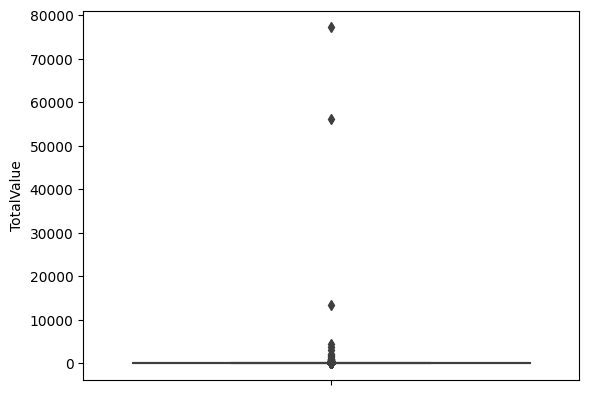

In [26]:
sns.boxplot(data=frequency, y='TotalValue')

## Criando o DataFrame final **RFV**

In [27]:
rfv = recency.merge(frequency, on='CustomerID', how='left')
rfv.head()

,CustomerID,Recency,Frequency,TotalValue
0,12346.0,11,1,77183.60
1,12347.0,0,182,23.68
2,12348.0,3,31,57.98
3,12349.0,1,73,24.08
4,12350.0,10,17,19.67


In [28]:
rfv.isnull().sum()

CustomerID    0
Recency       0
Frequency     0
TotalValue    0
dtype: int64

# Segmentação com KMeans

In [29]:
# Escalonar os dados é de suma importancia para o KMeans
from sklearn.preprocessing import StandardScaler

features = ['Recency',	'Frequency',	'TotalValue']
# Criamos esse df auxiliar para que ao final da clusterizão a gente possua o df com os dados antes de escalonar, para passar para a gerencia, por exemplo
rfv_scaled = rfv.copy()

scaler = StandardScaler()
scaler.fit(rfv[features]) # Treinamos nos dados originais

# Transformamos as features e jogamos no dataset escalonado
scaler_features = scaler.transform(rfv[features])
rfv_scaled[features] = scaler_features

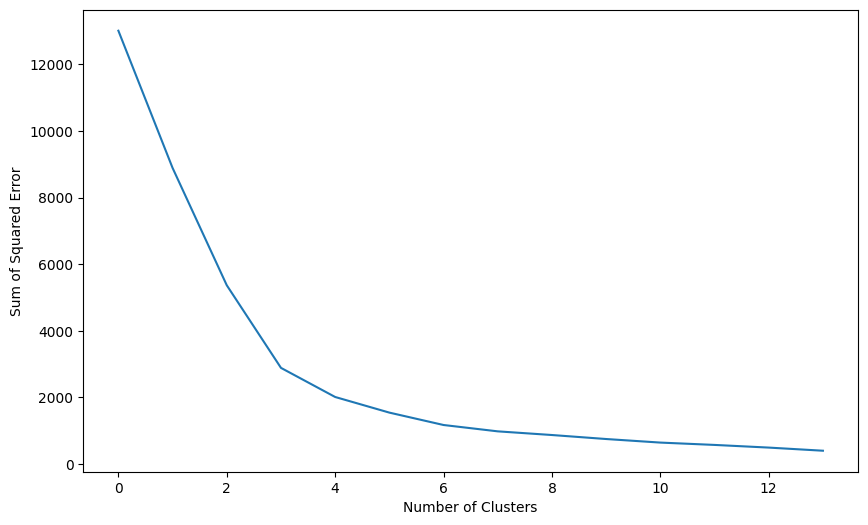

In [30]:
from sklearn.cluster import KMeans

sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfv_scaled[features])
    sse.append(kmeans.inertia_)


# Elbow method plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(sse)
# plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()


Na teoria, a quantidade de cluster mais apropriada para esse conjunto de dados seria 3, porem para o mundo dos negicios talvez seja uma segmentação com poucos grupos, o ideal seria testar algum valor entre 3~6

In [31]:
# Treinando
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfv_scaled[features])  # Não usaremos o ID do cliente para o treinamento pois ele nao diz nada sobre o agrupamento

# Atribuindo rotulos ao DF
rfv['Cluster'] = kmeans.labels_ # Ao DF inicial
rfv.head()

,CustomerID,Recency,Frequency,TotalValue,Cluster
0,12346.0,11,1,77183.60,1
1,12347.0,0,182,23.68,2
2,12348.0,3,31,57.98,2
3,12349.0,1,73,24.08,2
4,12350.0,10,17,19.67,0


In [32]:
rfv.describe()

,CustomerID,Recency,Frequency,TotalValue,Cluster
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,3.222453,91.720609,68.350452,1.473029
std,1721.808492,3.284536,228.785094,1467.918896,0.880887
min,12346.000000,0.000000,1.000000,2.100000,0.000000
25%,13813.250000,1.000000,17.000000,12.370000,0.000000
50%,15299.500000,2.000000,41.000000,17.725000,2.000000
75%,16778.750000,5.000000,100.000000,24.857500,2.000000
max,18287.000000,12.000000,7847.000000,77183.600000,2.000000


Tentando entender melhor os clusters

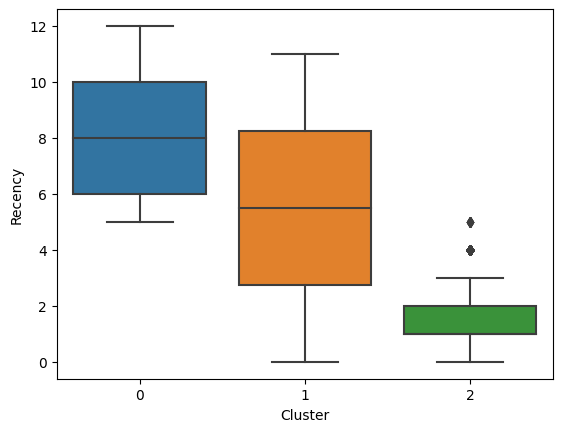

In [33]:
_ = sns.boxplot(x='Cluster', y='Recency', data=rfv)

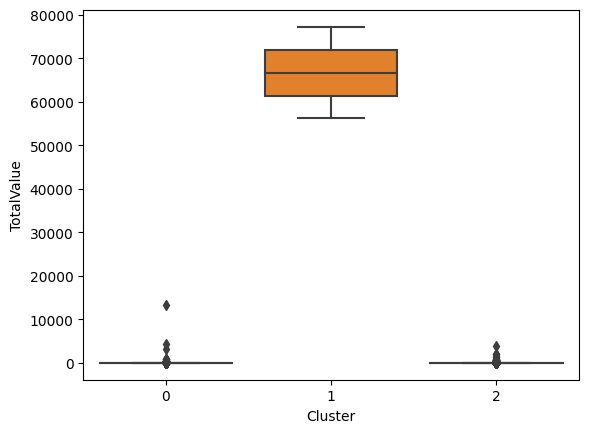

In [34]:
_ = sns.boxplot(x='Cluster', y='TotalValue', data=rfv)

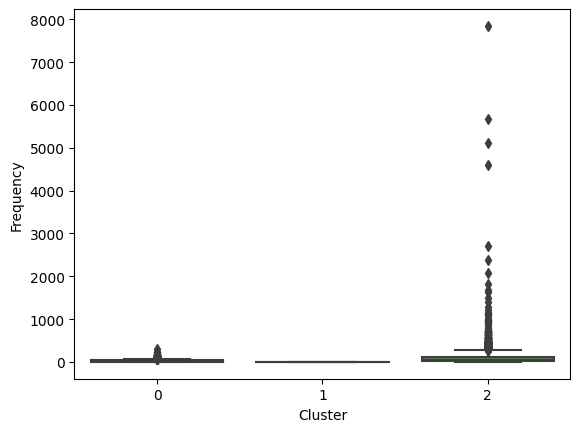

In [35]:
_ = sns.boxplot(x='Cluster', y='Frequency', data=rfv)

- **CLUSTER** 0: Ultima compra *há muito tempo*, Frequencia *media*, compras *medianas*
- **CLUSTER** 1: Ultima compra *recentemente*, Frequencia *alta*, compras *medianas*
- **CLUSTER** 2: Ultima compra *há um tempo*, Frequencia *baixa*, Compras *muito valiosas*

Outra forma de analisar os clusters:

In [36]:
# Vamos verificar as metricas por cluster
centroid_df = (
    rfv.groupby("Cluster")
  [["CustomerID", "Recency", "Frequency", "TotalValue"]]
    .agg(
        {
          "CustomerID": "nunique",
          "Recency": "mean",
          "Frequency": "mean",
          "TotalValue": "mean",
        }
    )
    .reset_index()
)

# Renomeamos a feature CustomerID
centroid_df = centroid_df.rename(columns={"CustomerID": "N_Clients"})

# Vamos ordenar por recencia
centroid_df.sort_values(by="Recency", ascending=True)

,Cluster,N_Clients,Recency,Frequency,TotalValue
2,2,3194,1.481215,114.380401,32.510783
1,1,2,5.500000,2.000000,66670.550000
0,0,1142,8.088441,28.501751,51.947215


Poderiamos dividir esses clientes em Clientes com alta frequencia, clientes com muito valor monetario(VIP) e clientes com possibilidade de churn

Percebemos que temos um cluster com apenas 2 clientes, fazendo com que essa clusterização pode nao ter sido tao eficiente, talvez seria interessante tirar esses 2 registros e rodar de novo, ou talvez aumentar o numero de cluster, mudar o algoritmo, enfim, existem muitas tecnicas para melhorar a segmentação, mas é importante **SEMPRE ANALISAR BEM OS CLUSTER GERADOS** para entender se eles fazem, sentido ou nao